In [1]:
# Let's keep our notebook clean, so it's a little more readable!
import warnings
warnings.filterwarnings('ignore')

In [23]:
%matplotlib inline

# Section 2: Machine learning to predict age from resting-state functional data

We will integrate what we've learned in the previous sections to extract data from *several* rs-fmri images, and use that data as features in a machine learning model

We will use a dataset consisting of children (ages 3-13) and young adults (ages 18-39). Using brain connectivity matrices from resting-state functional imaging, we will try to predict who are adults and who are children.

### Step 1: Loading the data


We are using data available in the latest release of nilearn. Make sure you installed this version specifically: pip install nilearn==0.6.0b0 

In [98]:
from nilearn import datasets

development_dataset = datasets.fetch_development_fmri(n_subjects=90) 
#The whole dataset consists of 155 participants, let's use 90 to save time

Let's see what the dataset contains!

In [99]:
development_dataset.description

b"The movie watching based brain development dataset (fMRI)\n\n\nNotes\n-----\nThis functional MRI dataset is used for teaching how to use\nmachine learning to predict age from naturalistic stimuli (movie)\nwatching with Nilearn.\n\nThe dataset consists of 50 children (ages 3-13) and 33 young adults (ages\n18-39). This dataset can be used to try to predict who are adults and\nwho are children.\n\nThe data is downsampled to 4mm resolution for convenience. The original\ndata is downloaded from OpenNeuro.\n\nFor full information about pre-processing steps on raw-fMRI data, have a look\nat README at https://osf.io/wjtyq/\n\nFull pre-processed data: https://osf.io/5hju4/files/\n\nRaw data can be accessed from : https://openneuro.org/datasets/ds000228/versions/1.0.0\n\nContent\n-------\n    :'func': functional MRI Nifti images (4D) per subject\n    :'confounds': TSV file contain nuisance information per subject\n    :'phenotypic': Phenotypic informaton for each subject such as age,\n        

How many individual subjects do we have?

In [100]:
len(development_dataset.func)

90

In [101]:
# Let's load the phenotype data
pheno=development_dataset.phenotypic

In [102]:
type(pheno)

numpy.ndarray

### Step 2- Generate connectivity matrices from brain signal

Here, we are going to use a brain parcellation to extract rs-fmri connectivity features from every subject.
A brain parcellation consists of a set of ROI from which we want to extract brain signal. Each ROI has its own value, these values are treated as labels. We will use nilearn.input_data.NiftiLabelsMasker.


In [108]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets

#First, let's load a parcellation that we'd like to use
multiscale = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = multiscale.scale064

print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /Users/cdeback/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


We can have a look at the atlas we are going to use!

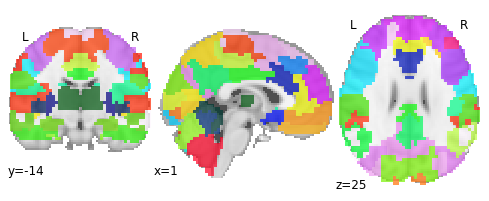

In [109]:
from nilearn import plotting

plotting.plot_roi(atlas_filename, draw_cross=False)

In [ ]:
# We are ready to extract brain signal from our chosen brain parcellation
# initialize the masker from which we will retrieve a 2D array
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)

After we extracting brain signal from all ROIs, we are ready to build a "connectome", i.e. a map of the connections in the brain. Since we’re working with functional data, however, we don’t have access to actual connections. Instead, we’ll use a measure of statistical dependency to infer the (possible) presence of a connection.

Here, we’ll use Pearson’s correlation as our measure of statistical dependency and compare how all of our ROIs from our chosen parcellation relate to one another.

In [129]:
# initialize correlation measure, to build a "connectome"
#set to vectorize (ready for machine learning!)
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

In [132]:
# Different options for connectivity: matrix or vector 
vectorized = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
not_vectorized = ConnectivityMeasure(kind='correlation', vectorize=False)

Let's generate data for one participant as an example and compare the difference when removing confounds or not!

In [116]:
# example with one participant
sub = development_dataset.func[0]
conf = development_dataset.confounds[0]

# Extract brain signal
time_series = masker.fit_transform(sub, confounds=conf)
time_series_conf = masker.fit_transform(sub)

In [115]:
time_series.shape

(168, 64)

Let's create the "connectome" or connectivity matrix and compare the effects of removing confounds or not!

In [117]:
matrix_removed_conf = not_vectorized.fit_transform([time_series])[0]
matrix_with_conf = not_vectorized.fit_transform([time_series_conf])[0]

Let's visualize the 2 connectivity matrices. How do they differ?

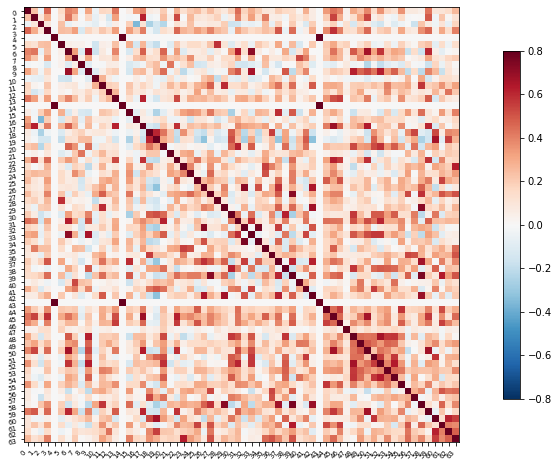

In [118]:
plotting.plot_matrix(matrix_removed_conf, figure=(10, 8), 
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

plotting.show()

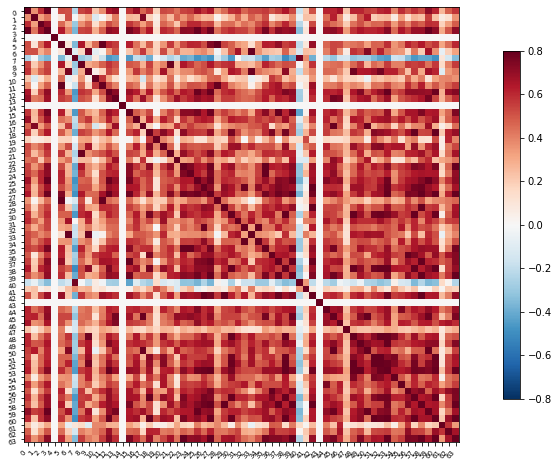

In [120]:
# Let's visualize the correlation matrix from which confounds have not been removed
plotting.plot_matrix(matrix_with_conf, figure=(10, 8), 
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

plotting.show()

You can see how important it is to remove confounds! 

To prepare data for machine learning more easily, we can also directly extract the connectivity in a vector

In [134]:
vector_removed_conf = vectorized.fit_transform([time_series])[0]


vector_removed_conf.shape

(2016,)

# Step 3 - Extracting brain features for all participants

Okay -- now we know how to generate brain signal without confounds and how to generate vectors that will be used as inputs in our machine learning model.

Let's apply those steps to our 90 participants!

**NOTE**: On a laptop, this might a few minutes.

We will extract data for each participant sequentially and append the vectors one after another.

In [135]:
# simple example
container = []
for i in range(10):
    container.append(i)

container

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [85]:
all_features = [] # here is where we will put the data (a container)

# Iterate through all participants
for (func, confounds) in zip(development_dataset.func, development_dataset.confounds):
# extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(func, confounds)
# create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# add to our container
    all_features.append(correlation_matrix)
    # keep track of status
    print('finished %s of %s'%(func,len(development_dataset.func)))

finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar125_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar126_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar127_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar128_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar129_task

finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar036_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar037_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar038_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar039_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar040_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar041_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz of 90
finished /Users/cdeback/nilearn_data/development_fmri/development_fmri/sub-pixar042_task

In [137]:
print(type(all_features))

#Convert list of features into a np array

import numpy as np
from numpy import array

X_features=array(all_features)

<class 'list'>


In [138]:
X_features.shape

(90, 2016)

In [139]:
# Let's save the data to disk
import numpy as np

np.savez_compressed('/Users/cdeback/Documents/MAIN2019_BASC064_subsamp_features',a = all_features)

In case you do not want to run the full loop on your computer, you can load the output of the loop here!

In [10]:
feat_file = 'MAIN_BASC064_subsamp_features.npz'
X_features = np.load(feat_file)['a']

In [140]:
X_features.shape

(90, 2016)

Okay so we've got our features.

We can visualize our feature matrix

Text(0, 0.5, 'subjects')

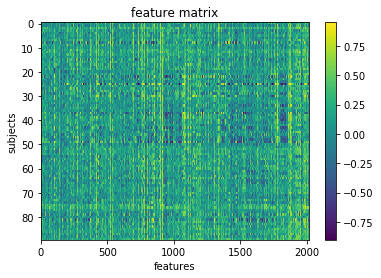

In [141]:
import matplotlib.pyplot as plt

plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

### Get Y (our target --> child vs adults) and assess its distribution

In [143]:
len(pheno)

90

In [148]:
pheno

array([('sub-pixar123', 27.06      , 'Adult', 'adult', 'F', 'R'),
       ('sub-pixar124', 33.44      , 'Adult', 'adult', 'M', 'R'),
       ('sub-pixar125', 31.        , 'Adult', 'adult', 'M', 'R'),
       ('sub-pixar126', 19.        , 'Adult', 'adult', 'F', 'R'),
       ('sub-pixar127', 23.        , 'Adult', 'adult', 'F', 'R'),
       ('sub-pixar128', 27.        , 'Adult', 'adult', 'M', 'R'),
       ('sub-pixar129', 23.        , 'Adult', 'adult', 'F', 'R'),
       ('sub-pixar130', 21.        , 'Adult', 'adult', 'F', 'R'),
       ('sub-pixar131', 39.        , 'Adult', 'adult', 'M', 'R'),
       ('sub-pixar132', 22.        , 'Adult', 'adult', 'F', 'R'),
       ('sub-pixar133', 21.        , 'Adult', 'adult', 'M', 'R'),
       ('sub-pixar134', 25.        , 'Adult', 'adult', 'M', 'R'),
       ('sub-pixar135', 21.        , 'Adult', 'adult', 'F', 'R'),
       ('sub-pixar136', 25.        , 'Adult', 'adult', 'F', 'R'),
       ('sub-pixar137', 34.        , 'Adult', 'adult', 'F', 'R'),
       ('s

In [149]:
# Looks like there is a column labeling children and adults. Let’s capture it in a variable
group = [pheno['Child_Adult'] for pheno in development_dataset.phenotypic]

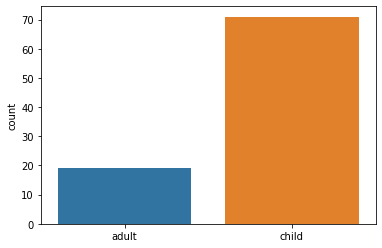

In [150]:
# Maybe we should have a look at the distribution of our target variable! 

import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(group)

In [152]:
#Convert group into a numpy array
import numpy as np 

y_ageclass=list(groups)

print(y_ageclass.count("child"))
print(y_ageclass.count("adult"))

71
19


We are a bit unbalanced -- there seems to be more children than adults

### Step 4 - Prepare data for machine learning

Here, we will define a "training sample" where we can play around with our models. We will also set aside a "test" sample that we will not touch until the end

We want to be sure that our training and test sample are matched! We can do that with a "stratified split". Specifically, we will stratify by age class.

In [154]:
from sklearn.model_selection import train_test_split

# Split the sample to training/test with a 70/30 ratio, and 
# stratify by age class, and also shuffle the data.

X_train, X_test, y_train, y_test = train_test_split(
                                                    X_features, # x
                                                    y_ageclass, # y
                                                    test_size = 0.3, # 70%/30% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = y_ageclass, # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_test))

training: 63 testing: 27


Let's visualize the distributions to be sure they are matched

Text(0.5, 1.0, 'Test')

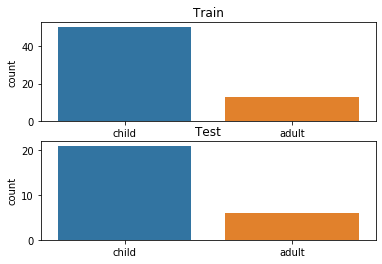

In [155]:
fig,(ax1,ax2) = plt.subplots(2)
sns.countplot(y_train, ax=ax1, order=['child','adult'])
ax1.set_title('Train')
sns.countplot(y_test, ax=ax2, order=['child','adult'])
ax2.set_title('Test')

### Run your first model!

Machine learning can get pretty fancy pretty quickly. We'll start with a very standard classification model called a Support Vector Classifier (SVC). 

While this may seem unambitious, simple models can be very robust. And we don't have enough data to create more complex models.

For more information, see this excellent resource:
https://hal.inria.fr/hal-01824205

First, a quick review of SVM!
![](https://docs.opencv.org/2.4/_images/optimal-hyperplane.png)

Let's fit our first model!

In [156]:
from sklearn.svm import SVC
l_svc = SVC(kernel='linear') # define the model

l_svc.fit(X_train, y_train) # fit the model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Well... that was easy. Let's see how well the model learned the data!

We can judge our model on several criteria:
* Accuracy: The proportion of predictions that were correct overall.
* Precision: Accuracy of cases predicted as positive
* Recall: Number of true positives correctly predicted to be positive
* f1 score: A balance between precision and recall

Or, for a more visual explanation...

![](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

In [157]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score

# predict the training data based on the model
y_pred = l_svc.predict(X_train) 

# caluclate the model accuracy
acc = l_svc.score(X_train, y_train) 

# calculate the model precision, recall and f1, all in one convenient report!
cr = classification_report(y_true=y_train,
                      y_pred = y_pred)

# get a table to help us break down these scores
cm = confusion_matrix(y_true=y_train, y_pred = y_pred) 


In [161]:
cm

array([[13,  0],
       [ 0, 50]])

Let's view our results and plot them all at once!

accuracy: 1.0
              precision    recall  f1-score   support

       adult       1.00      1.00      1.00        13
       child       1.00      1.00      1.00        50

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



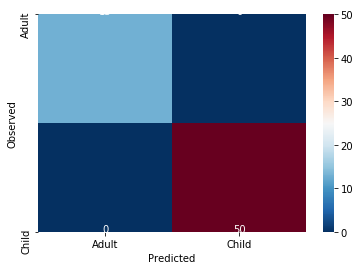

In [164]:
import itertools
from pandas import DataFrame

# print results
print('accuracy:', acc)
print(cr)

# plot confusion matrix
cmdf = DataFrame(cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap = 'RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
# label cells in matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

![](https://sebastianraschka.com/images/faq/multiclass-metric/conf_mat.png)

HOLY COW! Machine learning is amazing!!! Almost a perfect fit!

...which means there's something wrong. What's the problem here?

In [165]:
from sklearn.model_selection import cross_val_predict, cross_val_score

# predict
y_pred = cross_val_predict(l_svc, X_train, y_train, 
                           groups=y_train, cv=10)
# scores
acc = cross_val_score(l_svc, X_train, y_train, 
                     groups=y_train, cv=10)

We can look at the accuracy of the predictions for each fold of the cross-validation

In [166]:
for i in range(10):
    print('Fold %s -- Acc = %s'%(i, acc[i]))

Fold 0 -- Acc = 1.0
Fold 1 -- Acc = 0.8571428571428571
Fold 2 -- Acc = 1.0
Fold 3 -- Acc = 1.0
Fold 4 -- Acc = 1.0
Fold 5 -- Acc = 1.0
Fold 6 -- Acc = 1.0
Fold 7 -- Acc = 0.8333333333333334
Fold 8 -- Acc = 1.0
Fold 9 -- Acc = 1.0


We can also look at the overall accuracy of the model

In [169]:
from sklearn.metrics import accuracy_score
overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)

print('Confusion matrix:')
print(overall_cm)


Accuracy: 0.9682539682539683
              precision    recall  f1-score   support

       adult       1.00      0.85      0.92        13
       child       0.96      1.00      0.98        50

    accuracy                           0.97        63
   macro avg       0.98      0.92      0.95        63
weighted avg       0.97      0.97      0.97        63

Confusion matrix:
[[11  2]
 [ 0 50]]


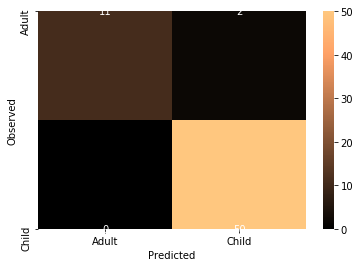

In [174]:
thresh = overall_cm.max() / 2
cmdf = DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center", verticalalignment="center",
                 color="white")

Not too bad at all!

### Tweak your model

It's very important to learn when and where its appropriate to "tweak" your model.

Since we have done all of the previous analysis in our training data, it's find to try different models. But we **absolutely cannot** "test" it on our left out data. If we do, we are in great danger of overfitting.

We could try other models, or tweak hyperparameters, but we are probably not powered sufficiently to do so, and would once again risk overfitting.


But as a demonstration, we could see the impact of "scaling" our data. Certain machine learning algorithms perform better when all the input data is transformed to a uniform range of values. This is often between 0 and 1, or mean centered around with unit variance. We can perhaps look at the performance of the model after scaling the data

In [27]:
# Scale the training data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train_scl = scaler.transform(X_train)

Text(0,0.5,'subjects')

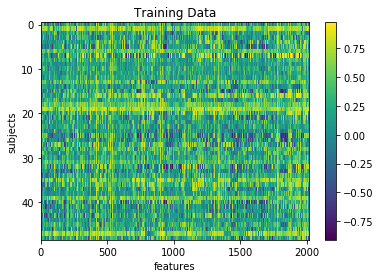

In [28]:
plt.imshow(X_train, aspect='auto')
plt.colorbar()
plt.title('Training Data')
plt.xlabel('features')
plt.ylabel('subjects')

Text(0,0.5,'subjects')

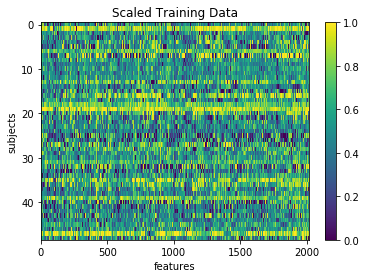

In [29]:
plt.imshow(X_train_scl, aspect='auto')
plt.colorbar()
plt.title('Scaled Training Data')
plt.xlabel('features')
plt.ylabel('subjects')

Accuracy: 0.877551020408
              precision    recall  f1-score   support

       adult       0.88      0.79      0.83        19
       child       0.88      0.93      0.90        30

   micro avg       0.88      0.88      0.88        49
   macro avg       0.88      0.86      0.87        49
weighted avg       0.88      0.88      0.88        49



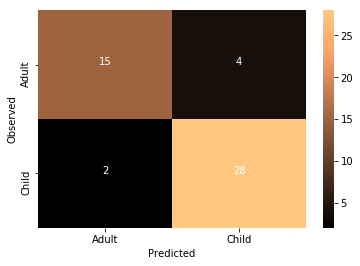

In [30]:
# repeat the steps above to re-fit the model 
# and assess its performance

# don't forget to switch X_train to X_train_scl

# predict
y_pred = cross_val_predict(l_svc, X_train_scl, y_train, 
                           groups=y_train, cv=10)

# get scores
overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)

# plot
thresh = overall_cm.max() / 2
cmdf = DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

What do you think about the results of this model compared to the non-transformed model?

**Exercise:** Try fitting a new SVC model and tweak one of the many parameters. Run cross-validation and see how well it goes. Make a new cell and type SVC? to see the possible hyperparameters

In [31]:
# new_model = SVC() 

### Can our model classify childrens from adults in completely un-seen data?
Now that we've fit a model we think has possibly learned how to decode childhood vs adulthood based on rs-fmri signal, let's put it to the test. We will train our model on all of the training data, and try to predict the age of the subjects we left out at the beginning of this section.

Because we performed a transformation on our training data, we will need to transform our testing data using the *same information!* 


In [32]:
# Notice how we use the Scaler that was fit to X_train and apply to X_test,
# rather than creating a new Scaler for X_test
X_test_scl = scaler.transform(X_test)

And now for the moment of truth! 

No cross-validation needed here. We simply fit the model with the training data and use it to predict the testing data

I'm so nervous. Let's just do it all in one cell

accuracy = 0.882352941176
              precision    recall  f1-score   support

       adult       0.92      0.79      0.85        14
       child       0.86      0.95      0.90        20

   micro avg       0.88      0.88      0.88        34
   macro avg       0.89      0.87      0.88        34
weighted avg       0.89      0.88      0.88        34



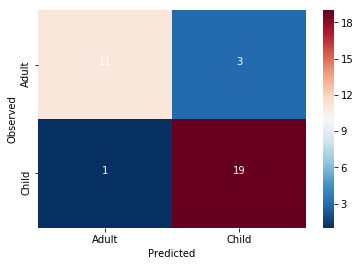

In [33]:
l_svc.fit(X_train_scl, y_train) # fit to training data
y_pred = l_svc.predict(X_test_scl) # classify age class using testing data
acc = l_svc.score(X_test_scl, y_test) # get accuracy
cr = classification_report(y_pred=y_pred, y_true=y_test) # get prec., recall & f1
cm = confusion_matrix(y_pred=y_pred, y_true=y_test) # get confusion matrix

# print results
print('accuracy =', acc)
print(cr)

# plot results
thresh = cm.max() / 2
cmdf = DataFrame(cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap='RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

***Wow!!*** Congratulations. You just trained a machine learning model that used real rs-fmri data to predict the age of real humans.

It seems like something in this data does seem to be systematically related to age ... but what?  